### Amazon Dataset Exploration

Let's see what we can discover about this dataset that might be useful in our models.

In [1]:
import pandas as pd
import numpy
import gzip
from collections import defaultdict

In [5]:
# Import Select Columns

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)
    
reviews = []
# for l in readGz("/content/drive/My Drive/train.json.gz"):
for l in readGz("train.json.gz"):
    reviews.append(l['reviewText'])
    
categories = []
# for l in readGz("/content/drive/My Drive/train.json.gz"):
for l in readGz("train.json.gz"):
    categories.append(l['categoryID'])

In [7]:
# Import all cols for preview
train_allcols = []
for l in readGz("train.json.gz"):
    train_allcols.append(l)
    
train_allcols[0]

{'reviewTime': '09 26, 2013',
 'reviewText': "The model in this picture has them rolled up at the top because they are actually very high waisted! that's my only complaint though, because they are very good quality, and fit really well! I am 5'2&#34; 120lbs with thick thighs and i love them i can't wait to wear them out!",
 'helpful': {'nHelpful': 0, 'outOf': 0},
 'reviewerID': 'U490934656',
 'reviewHash': 'R798569390',
 'categories': [['Clothing, Shoes & Jewelry', 'Women'],
  ['Clothing, Shoes & Jewelry',
   'Novelty, Costumes & More',
   'Novelty',
   'Clothing',
   'Women',
   'Leggings']],
 'unixReviewTime': 1380153600,
 'itemID': 'I402344648',
 'rating': 4.0,
 'summary': 'High Waisted',
 'categoryID': 0}

In [8]:
# Import Test data

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)
   
test_users = []
for l in readGz("test_Category.json.gz"):
    test_users.append(l['reviewerID'])
    
test_allcol = []
for l in readGz("test_Category.json.gz"):
    test_allcol.append(l)

In [9]:
test_allcol[0]

{'reviewTime': '07 26, 2013',
 'reviewText': 'I love this blouse, in fact I have it on right now....all of my friends like it and want one.',
 'helpful': {'nHelpful': 9, 'outOf': 9},
 'reviewerID': 'U281659737',
 'reviewHash': 'R934811302',
 'unixReviewTime': 1374796800,
 'rating': 5.0,
 'summary': 'love it'}

In [10]:
# Check the reviewers in the training data, and see if any of them appear in the test data

train_users = []
for l in readGz("train.json.gz"):
    train_users.append(l['reviewerID'])

    
test_users = []
for l in readGz("test_Category.json.gz"):
    test_users.append(l['reviewerID'])


In [29]:
# Convert to Pandas df
train_users_df = pd.DataFrame(train_users, columns = ['ReviewerID'])
test_users_df = pd.DataFrame(test_users, columns = ['ReviewerID'])

train_users_df.head()

,ReviewerID
0,U490934656
1,U714157797
2,U507366950
3,U307862152
4,U742726598


In [30]:
# Users with most reviews
pd.value_counts(train_users_df['ReviewerID'])

U897446633    108
U761252500     57
U117785953     57
U232908133     48
U026509570     47
             ... 
U599505683      1
U371657250      1
U825667828      1
U272527284      1
U916222473      1
Name: ReviewerID, Length: 39239, dtype: int64

In [31]:
pd.value_counts(test_users_df['ReviewerID'])

U761252500    8
U610878400    6
U117785953    6
U411608196    6
U263068464    6
             ..
U371792113    1
U817459023    1
U776105764    1
U276238811    1
U749092797    1
Name: ReviewerID, Length: 11698, dtype: int64

In [32]:
# Summarize review counts by user in both the training set and the test set
train_users_df['ReviewCount'] = 1

train_user_counts = train_users_df.groupby(['ReviewerID']).sum()['ReviewCount']
train_user_counts.head()

ReviewerID
U000005569     5
U000024709    10
U000041850     8
U000089279     2
U000131684     3
Name: ReviewCount, dtype: int64

In [33]:
test_users_df['ReviewCount'] = 1

test_user_counts = test_users_df.groupby(['ReviewerID']).sum()['ReviewCount']
test_user_counts.head()

ReviewerID
U000024709    1
U000243198    1
U000382648    1
U000442276    3
U000446326    1
Name: ReviewCount, dtype: int64

In [34]:
print("Training set reviewers: ", len(train_user_counts))
print("Test set reviewers: ", len(test_user_counts))

Training set reviewers:  39239
Test set reviewers:  11698


In [36]:
reviewers_merge = pd.merge(train_user_counts, test_user_counts, how = 'inner', 
                           on = ['ReviewerID'], suffixes = ('Train', 'Test'))
reviewers_merge.head()

,ReviewCountTrain,ReviewCountTest
ReviewerID,,
U000024709,10,1
U000243198,3,1
U000382648,7,1
U000442276,17,3
U000446326,4,1


In [37]:
len(reviewers_merge)

11658

In [39]:
pct_seen = len(reviewers_merge) / len(test_user_counts)
print("Pct of test users previously seen: ", pct_seen)

Pct of test users previously seen:  0.9965806120704394


In [41]:
reviewers_merge['ReviewCountTrain'].mean()

5.416452221650369

Text(0.5, 1.0, 'Histogram of Previously Seen Reviews per Test Reviewer')

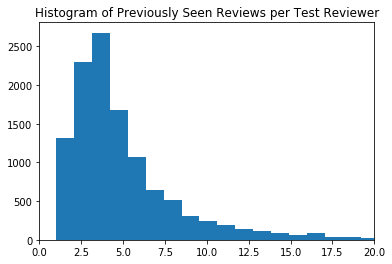

In [61]:
from matplotlib import pyplot as plt
plt.hist(reviewers_merge['ReviewCountTrain'], bins = 100)
plt.xlim(0, 20)
plt.title('Histogram of Previously Seen Reviews per Test Reviewer')

In [44]:
# We can get a better view of this with the Empirical CDF

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

Text(0.5, 1.0, 'ECDF of Previously Seen Reviews per Test Reviewer')

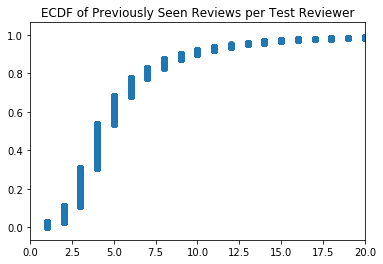

In [62]:
import numpy as np
x, y = ecdf(reviewers_merge['ReviewCountTrain'])
plt.scatter(x, y )
plt.xlim(0, 20)
plt.title('ECDF of Previously Seen Reviews per Test Reviewer')

### Key Finding

The vast majority (>99%) of reviewers in the test data have already been seen in the training data, with 3-5 previous reviews being typical. This means that there might be predictive feature information about the reviewers that could be used to augment the text classification prediction. For example, it might turn out that many users tend to buy most or all of their purchases in a single category. We should experiment with this further.